In [1]:
import sys
import os
import json
import glob
import h5py

import numpy as np
import scipy.signal
import scipy.io.wavfile
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import importlib

sys.path.append('/om2/user/msaddler/python-packages/bez2018model')
import bez2018model
importlib.reload(bez2018model)

sys.path.append('assets_psychophysics')
import util_figures
importlib.reload(util_figures)
import util_figures_stimuli
importlib.reload(util_figures_stimuli)

sys.path.append('assets_datasets')
import util_stimuli
importlib.reload(util_stimuli)


<module 'util_stimuli' from '/om2/user/msaddler/pitchnet/assets_datasets/util_stimuli.py'>

In [2]:
kwargs_nervegram_meanrates = {
    'meanrates_params': {
        'dur': 0.050,
        'fs':20e3,
        'buffer_start_dur': 0.07,
        'buffer_end_dur': 0.01,
    },
    'ANmodel_params': {
        'num_cfs': 100,
        'min_cf':125,
        'max_cf':14e3,
        'spont_list':[70.0],
        'cohc':1.0,
        'bandwidth_scale_factor':1.0,
        'IhcLowPass_cutoff': 3000.0,
        'IhcLowPass_order': 7,
    },
}


# sr = 32000
# t = np.arange(0, 0.150, 1/sr)
# signal = np.zeros_like(t)
# noise = np.random.randn(signal.shape[0])
# f0 = 200
# phase_mode = 'sine'

# freq_list = f0*np.arange(1, 60)
# if phase_mode == 'alt':
#     phase_list = np.pi/2 * np.ones(len(freq_list))
#     phase_list[::2] = 0
# else:
#     phase_list = np.zeros(len(freq_list))
# for freq, phase in zip(freq_list, phase_list):
#     if freq < sr/2:
#         signal = signal + np.sin(2*np.pi*freq*t + phase)

# snr = 12
# dBSPL = 60
# noise = np.random.randn(noise.shape[0])

# y = util_stimuli.combine_signal_and_noise(signal, noise, snr=snr,
#                                           rms_out=20e-6*np.power(10, dBSPL/20))

# fn = '/om/user/msaddler/data_pitchnet/oxenham2004/Oxenham2004_transposedTones_f0_080to320Hz/Oxenham2004_transposedTones_f0_080to320Hz.hdf5'
# f = h5py.File(fn, 'r')
# y = f['stimuli/signal'][3999]
# sr = f['sr'][0]
# f.close()

fn = '/om/scratch/Fri/msaddler/data_pitchnet/PND_v08/noise_TLAS_snr_neg10pos10/PND_sr32000_v08_0000000-0021000.hdf5'
f = h5py.File(fn, 'r')
IDX = 14184#np.random.randint(f['stimuli/signal'].shape[0])
signal = f['stimuli/signal'][IDX]
noise = f['stimuli/noise'][IDX]
f0 = f['nopad_f0_mean'][IDX]
print(IDX, f0)
sr = f['sr'][0]
f.close()

snr = 10
dBSPL = 60

y = util_stimuli.combine_signal_and_noise(signal, noise, snr=snr,
                                          rms_out=20e-6*np.power(10, dBSPL/20))

ipd.display(ipd.Audio(y, rate=sr))


14184 207.65234


In [3]:
out_dict = bez2018model.nervegram_meanrates(y, sr, **kwargs_nervegram_meanrates)


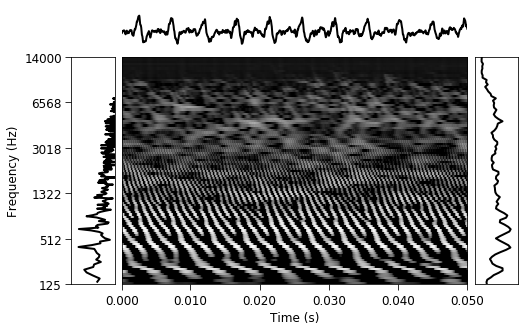

In [4]:
import util_figures
importlib.reload(util_figures)
import util_figures_stimuli
importlib.reload(util_figures_stimuli)

figsize=(8, 5)
nrows=2
ncols=3
gridspec_kw = {
    'wspace': 0.05,
    'hspace': 0.05,
    'width_ratios': [1, 8, 1],
    'height_ratios': [1, 6],
}
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, gridspec_kw=gridspec_kw)

util_figures_stimuli.figure_wrapper_nervegram_stimulus(ax_arr,
    ax_idx_nervegram=4,
    ax_idx_spectrum=3,
    ax_idx_excitation=5,
    ax_idx_waveform=1,
    nervegram=out_dict['meanrates'],
    nervegram_sr=out_dict['meanrates_fs'],
    waveform=out_dict['pin'],
    waveform_sr=out_dict['pin_fs'],
    cfs=out_dict['cf_list'],
    fontsize_title=12,
    fontsize_labels=12,
    fontsize_legend=12,
    fontsize_ticks=12,
    fontweight_labels=None,
    plot_kwargs={'lw':2},
    limits_buffer=0.2,
    nxticks=6, 
    nyticks=6,
    spines_to_hide_spectrum=[],
    spines_to_hide_excitation=[],
    spines_to_hide_waveform=['top', 'bottom', 'left', 'right'])

plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/'
# save_fn = os.path.join(save_dir, 'tmp_schematic_training_stimulus_{}_nervegram_noise.pdf'.format(IDX))
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)



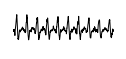

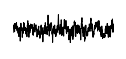

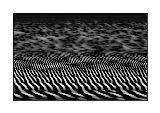

In [4]:
figsize = (1.8, 0.6)
tmin = 0.075
tmax = 0.121
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax = util_figures_stimuli.figure_wrapper_nervegram_stimulus(ax,
                                      ax_idx_nervegram=None,
                                      ax_idx_spectrum=None,
                                      ax_idx_excitation=None,
                                      ax_idx_waveform=0,
                                      waveform=signal,
                                      waveform_sr=sr,
                                      tmin=tmin,
                                      tmax=tmax,
                                      treset=True)
plt.show()
# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/'
# save_fn = os.path.join(save_dir, 'tmp_schematic_training_stimulus_{}_waveform_signal.pdf'.format(IDX))
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
ax = util_figures_stimuli.figure_wrapper_nervegram_stimulus(ax,
                                      ax_idx_nervegram=None,
                                      ax_idx_spectrum=None,
                                      ax_idx_excitation=None,
                                      ax_idx_waveform=0,
                                      waveform=noise,
                                      waveform_sr=sr,
                                      tmin=tmin,
                                      tmax=tmax,
                                      treset=True)
plt.show()
# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/'
# save_fn = os.path.join(save_dir, 'tmp_schematic_training_stimulus_{}_waveform_noise.pdf'.format(IDX))
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)


figsize=(2.4, 1.6)
nrows=1
ncols=1
fig, ax_arr = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
util_figures_stimuli.figure_wrapper_nervegram_stimulus(ax_arr,
                                  ax_idx_nervegram=0,
                                  ax_idx_spectrum=None,
                                  ax_idx_excitation=None,
                                  ax_idx_waveform=None,
                                  nervegram=out_dict['meanrates'],
                                  nervegram_sr=out_dict['meanrates_fs'],
                                  waveform=out_dict['pin'],
                                  waveform_sr=out_dict['pin_fs'],
                                  cfs=out_dict['cf_list'],
                                  fontsize_title=12,
                                  fontsize_labels=12,
                                  fontsize_legend=12,
                                  fontsize_ticks=12,
                                  fontweight_labels=None,
                                  plot_kwargs={'lw':2},
                                  limits_buffer=0.2,
                                  nxticks=0, 
                                  nyticks=0,
                                  spines_to_hide_spectrum=[],
                                  spines_to_hide_excitation=[],
                                  spines_to_hide_waveform=['top', 'bottom', 'left', 'right'])
ax_arr.set_xlabel(None)
ax_arr.set_ylabel(None)
plt.show()
# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2020_02_03_pitchnet_paper_figures/'
# save_fn = os.path.join(save_dir, 'tmp_schematic_training_stimulus_{}_nervegram_signal_in_noise.pdf'.format(IDX))
# fig.savefig(save_fn, bbox_inches='tight', pad_inches=0, transparent=True)


302


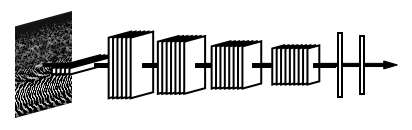

In [11]:
import os
import sys
import json
import copy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.transforms


def load_brain_arch(brain_arch_fn):
    '''
    '''
    with open(brain_arch_fn) as f:
        brain_arch_layer_list = json.load(f)
    return brain_arch_layer_list


def process_cnn_layer_list(brain_arch_layer_list, n_classes=700):
    '''
    '''
    layer_list = []
    for brain_arch_layer in brain_arch_layer_list:
        layer_type = brain_arch_layer['layer_type']
        layer_name = brain_arch_layer['args']['name']
        if 'conv2d' in layer_type:
            layer_dict = {
                'name': layer_name,
                'type': layer_type,
                'dim_n': brain_arch_layer['args']['filters'],
                'dim_h': brain_arch_layer['args']['kernel_size'][0],
                'dim_w': brain_arch_layer['args']['kernel_size'][1],
            }
            layer_list.append(layer_dict)
        elif 'dense' in layer_type:
            layer_dict = {
                'name': layer_name,
                'type': layer_type,
                'dim_n': brain_arch_layer['args']['units'],
            }
            layer_list.append(layer_dict)
        elif 'classification' in layer_type:
            layer_dict = {
                'name': layer_name,
                'type': layer_type,
                'dim_n': brain_arch_layer['args'].get('units', n_classes),
            }
            layer_list.append(layer_dict)
    return layer_list


def get_xy_from_center(center=(0, 0), w=1.0, h=1.0):
    '''
    '''
    xy = np.array([
        [center[0] - w/2, center[1] - h/2],
        [center[0] - w/2, center[1] + h/2],
        [center[0] + w/2, center[1] + h/2],
        [center[0] + w/2, center[1] - h/2],
    ])
    return xy


def get_dim_from_raw_value(raw_value, range_dim=None, scaling='log2'):
    '''
    '''
    dim = raw_value
    if scaling == 'log2':
        dim = np.log2(raw_value)
        if range_dim is not None:
            dim = np.min([dim + range_dim[0], range_dim[1]])
    elif scaling == 'linear':
        dim = raw_value
        if range_dim is not None:
            dim = np.max([range_dim[0], dim])
            dim = np.min([range_dim[1], dim])
    else:
        raise ValueError('Unrecognized scaling: {}'.format(scaling))
    return dim


def draw_cnn_from_layer_list(ax, layer_list,
                             key_dim_w='dim_w',
                             key_dim_h='dim_h',
                             key_dim_n='dim_n',
                             scaling_w='log2',
                             scaling_h='log2',
                             scaling_n='log2',
                             input_image=None,
                             input_buffer=0.0,
                             input_shadow=True,
                             input_shadow_to_scale=False,
                             gap_interlayer=1.0,
                             gap_intralayer=0.2,
                             deg_scale_x=60,
                             deg_skew_y=15,
                             deg_fc=0,
                             range_w=[5e-1, 1e1],
                             range_h=[5e-1, 1e1],
                             limits_buffer=1e-2,
                             arrow_buffer=1.5,
                             arrow_width=0.25,
                             scale_fc=1.0,
                             spines_to_hide = ['top', 'bottom', 'left', 'right'],
                             kwargs_polygon_update={},
                             kwargs_polygon_shadow_update={},
                             kwargs_arrow_update={}):
    '''
    '''
    kwargs_polygon = {
        'ec': 'k',
        'fc': 'w',
        'lw': 2,
        'fill': True,
        'alpha': 1.0,
    }
    kwargs_polygon.update(kwargs_polygon_update)
    kwargs_polygon_shadow = copy.deepcopy(kwargs_polygon)
    kwargs_polygon_shadow['alpha'] = 0.5
    kwargs_polygon_shadow['ec'] = 'w'
    kwargs_polygon_shadow['ls'] = '--'

    kwargs_polygon_shadow.update(kwargs_polygon_shadow_update)
    kwargs_arrow = {
        'width': arrow_width,
        'length_includes_head': True,
        'head_width': arrow_width * 2.5,
        'head_length': arrow_width * 2.5,
        'overhang': 0.0,
        'head_starts_at_zero': False,
        'color': 'k',
        'zorder': -1,
    }
    kwargs_arrow.update(kwargs_arrow_update)
    
    (xl, yl, zl) = (0, 0, 0)
    for itr_layer, layer in enumerate(layer_list):
        n = int(get_dim_from_raw_value(layer[key_dim_n], range_dim=None, scaling=scaling_n))
        if (key_dim_w in layer.keys()) and (key_dim_h in layer.keys()):
            w = get_dim_from_raw_value(layer[key_dim_w], range_dim=range_w, scaling=scaling_w)
            h = get_dim_from_raw_value(layer[key_dim_h], range_dim=range_h, scaling=scaling_h)
            for itr_sublayer in range(n):
                xy = get_xy_from_center(center=(xl, yl), w=w, h=h)
                patch = matplotlib.patches.Polygon(xy, **kwargs_polygon, zorder=zl)
                transform = matplotlib.transforms.Affine2D()
                transform = transform.translate(-xl, -yl)
                transform = transform.scale(np.cos(np.deg2rad(deg_scale_x)), 1)
                transform = transform.skew_deg(0, deg_skew_y)
                transform = transform.translate(xl, yl)
                patch.set_transform(transform + ax.transData)
                ax.add_patch(patch)
                zl += 1
                if itr_sublayer == n-1:
                    x_arrow = xl
                    y_arrow = yl
                    dx_arrow = gap_interlayer
                    dy_arrow = 0
                    ax.arrow(x_arrow, y_arrow, dx_arrow, dy_arrow,
                             width=arrow_width,
                             length_includes_head=True,
                             head_width=0,
                             head_length=0,
                             color=kwargs_arrow['color'],
                             zorder=zl)
                    zl += 1
                xl += gap_intralayer
        else:
            w = gap_intralayer
            h = n * scale_fc
            xy = get_xy_from_center(center=(xl, yl), w=w, h=h)
            patch = matplotlib.patches.Polygon(xy, **kwargs_polygon, zorder=zl)
            patch_im = ax.add_patch(patch)
            zl += 1
        xl += gap_interlayer
    
    x_arrow = -arrow_buffer * gap_interlayer
    dx_arrow = xl + arrow_buffer * gap_interlayer + kwargs_arrow['head_length']
    y_arrow = yl
    dy_arrow = 0
    ax.arrow(x_arrow, y_arrow, dx_arrow, dy_arrow, **kwargs_arrow)
    ax.update_datalim([[x_arrow, y_arrow], [x_arrow+dx_arrow, y_arrow+dy_arrow]])
    [xb, yb, dxb, dyb] = ax.dataLim.bounds
    
    if input_image is not None:
        x_input = x_arrow - input_buffer * gap_interlayer
        y_input = yl
        w = get_dim_from_raw_value(input_image.shape[1], range_dim=range_w, scaling=scaling_w)
        h = get_dim_from_raw_value(input_image.shape[0], range_dim=range_h, scaling=scaling_h)
        extent = np.array([x_input - w/2, x_input + w/2, y_input - h/2, y_input + h/2])
        im = ax.imshow(input_image,
                       cmap=matplotlib.cm.gray,
                       extent=extent,
                       aspect='auto',
                       origin='lower',
                       zorder=-3)
        transform = matplotlib.transforms.Affine2D()
        transform = transform.translate(-x_input, -y_input)
        transform = transform.scale(np.cos(np.deg2rad(deg_scale_x)), 1)
        transform = transform.skew_deg(0, deg_skew_y)
        transform = transform.translate(x_input, y_input)
        im.set_transform(transform + ax.transData)
        
        if input_shadow:
            if (key_dim_w in layer_list[0].keys()) and (key_dim_h in layer_list[0].keys()):
                if input_shadow_to_scale:
                    w = (layer_list[0][key_dim_w] / input_image.shape[1]) * w
                    h = (layer_list[0][key_dim_h] / input_image.shape[0]) * h
                else:
                    w = get_dim_from_raw_value(layer_list[0][key_dim_w],range_dim=range_w, scaling=scaling_w)
                    h = get_dim_from_raw_value(layer_list[0][key_dim_h], range_dim=range_h, scaling=scaling_h)
                xy = get_xy_from_center(center=(x_input, y_input), w=w, h=h)
                patch = matplotlib.patches.Polygon(xy, **kwargs_polygon_shadow, zorder=-2)
                patch.set_transform(transform + ax.transData)
                ax.add_patch(patch)
        
        M = transform.transform(extent.reshape([2, 2]).T)
        dyb = np.max([dyb, M[1, 1] - M[0, 1]])
        yb = np.min([yb, M[0, 1]])
        dxb = np.max([dxb, dxb + (xb - M[0, 0])])
        xb = np.min([xb, M[0, 0]])
    
    ax.set_xlim([xb - limits_buffer * dxb, xb + (1 + limits_buffer) * dxb])
    ax.set_ylim([yb - limits_buffer * dyb, yb + (1 + limits_buffer) * dyb])
    ax.set_xticks([])
    ax.set_yticks([])
    for spine_key in spines_to_hide:
        ax.spines[spine_key].set_visible(False)
    return ax


brain_arch_fn = '/om/scratch/Fri/msaddler/pitchnet/saved_models/arch_search_v01/arch_{:04.0f}/brain_arch.json'

for ARCH_N in [302]:# + np.random.randint(0, 302, 20).tolist():
    print(ARCH_N)
    brain_arch_layer_list = load_brain_arch(brain_arch_fn.format(ARCH_N))
    layer_list = process_cnn_layer_list(brain_arch_layer_list)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(len(layer_list), 2))
    draw_cnn_from_layer_list(ax, layer_list,
                             key_dim_w='dim_w',
                             key_dim_h='dim_h',
                             key_dim_n='dim_n',
#                              scaling_w='linear',
#                              scaling_h='linear',
                             scaling_n='log2',
                             input_image=np.squeeze(out_dict['meanrates']),
                             input_buffer=0.0,
                             input_shadow=True,
                             input_shadow_to_scale=True,
                             gap_interlayer=1.0,
                             gap_intralayer=0.2,
                             deg_scale_x=75,
                             deg_skew_y=25,
                             deg_fc=0,
                             range_w=[5e-1, 1e1],
                             range_h=[5e-1, 1e1],
                             limits_buffer=1e-2,
                             arrow_buffer=1.5,
                             arrow_width=0.25,
                             scale_fc=0.5,
                             spines_to_hide = ['top', 'bottom', 'left', 'right'],
                             kwargs_polygon_update={'lw': 2.0},
                             kwargs_polygon_shadow_update={},
                             kwargs_arrow_update={})
    plt.show()


302
conv_0 6.643856189774724 9.552669097514272 5
conv_1 6.357552004618084 7.139551352398794 6
conv_2 6.149747119504682 3.700439718141092 7
conv_3 4.169925001442312 2.807354922057604 8
conv_4 3.807354922057604 2.321928094887362 9


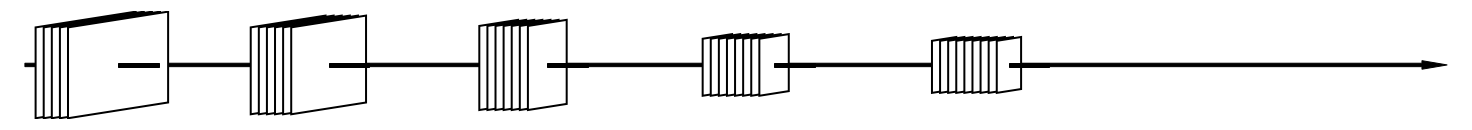

In [49]:
import os
import sys
import json
import copy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
import matplotlib.transforms

import tensorflow as tf
sys.path.append('/code_location/multi_gpu/')
import functions_brain_network


def load_brain_arch(brain_arch_fn):
    '''
    '''
    with open(brain_arch_fn) as f:
        brain_arch_layer_list = json.load(f)
    return brain_arch_layer_list


def process_cnn_layer_list(brain_arch_layer_list,
                           input_shape=[100, 1000],
                           n_classes_dict={'f0_label':700}):
    '''
    '''
    tf.reset_default_graph()
    if not input_shape[0] == 1:
        input_shape = [1] + list(input_shape)
    while len(input_shape) < 4:
        input_shape = input_shape + [1]
    input_tensor = tf.placeholder(tf.float32, shape=input_shape, name='input_tensor')
    output_tensor, nets = functions_brain_network.make_brain_net(input_tensor,
                                                                 n_classes_dict,
                                                                 brain_arch_layer_list,
                                                                 trainable=True,
                                                                 batchnorm_flag=True,
                                                                 dropout_flag=True,
                                                                 save_arch_path=None,
                                                                 save_pckl_path=None,
                                                                 only_include_layers=None)
    list_layer_dict = []
    for brain_arch_layer in brain_arch_layer_list:
        layer_name = brain_arch_layer['args']['name']
        layer_type = brain_arch_layer['layer_type']
        shape_activations = nets[layer_name].shape.as_list()
        shape_activations.pop(0)
        layer_dict = {
            'layer_name': layer_name,
            'layer_type': layer_type,
            'shape_activations': shape_activations,
        }
        if 'kernel_size' in brain_arch_layer['args']:
            layer_dict['shape_kernel'] = brain_arch_layer['args']['kernel_size']
        list_layer_dict.append(layer_dict)
    return list_layer_dict


def get_xy_from_center(center=(0, 0), w=1.0, h=1.0):
    '''
    '''
    xy = np.array([
        [center[0] - w/2, center[1] - h/2],
        [center[0] - w/2, center[1] + h/2],
        [center[0] + w/2, center[1] + h/2],
        [center[0] + w/2, center[1] - h/2],
    ])
    return xy


def get_dim_from_raw_value(raw_value, range_dim=None, scaling='log2'):
    '''
    '''
    dim = raw_value
    if scaling == 'log2':
        dim = np.log2(raw_value)
        if range_dim is not None:
            dim = np.min([dim + range_dim[0], range_dim[1]])
    elif scaling == 'linear':
        dim = raw_value
        if range_dim is not None:
            dim = np.max([range_dim[0], dim])
            dim = np.min([range_dim[1], dim])
    else:
        raise ValueError('Unrecognized scaling: {}'.format(scaling))
    return dim


def draw_cnn_from_layer_list(ax, layer_list,
                             key_dim_w='dim_w',
                             key_dim_h='dim_h',
                             key_dim_n='dim_n',
                             scaling_w='log2',
                             scaling_h='log2',
                             scaling_n='log2',
                             input_image=None,
                             input_buffer=0.0,
                             input_shadow=True,
                             input_shadow_to_scale=False,
                             gap_interlayer=1.0,
                             gap_intralayer=0.2,
                             deg_scale_x=60,
                             deg_skew_y=15,
                             deg_fc=0,
                             range_w=[5e-1, 1e1],
                             range_h=[5e-1, 1e1],
                             limits_buffer=1e-2,
                             arrow_buffer=1.5,
                             arrow_width=0.25,
                             scale_fc=1.0,
                             spines_to_hide = ['top', 'bottom', 'left', 'right'],
                             kwargs_polygon_update={},
                             kwargs_polygon_shadow_update={},
                             kwargs_arrow_update={}):
    '''
    '''
    kwargs_polygon = {
        'ec': 'k',
        'fc': 'w',
        'lw': 2,
        'fill': True,
        'alpha': 1.0,
    }
    kwargs_polygon.update(kwargs_polygon_update)
    kwargs_polygon_shadow = copy.deepcopy(kwargs_polygon)
    kwargs_polygon_shadow['alpha'] = 0.5
    kwargs_polygon_shadow['ec'] = 'w'
    kwargs_polygon_shadow['ls'] = '--'

    kwargs_polygon_shadow.update(kwargs_polygon_shadow_update)
    kwargs_arrow = {
        'width': arrow_width,
        'length_includes_head': True,
        'head_width': arrow_width * 2.5,
        'head_length': arrow_width * 2.5,
        'overhang': 0.0,
        'head_starts_at_zero': False,
        'color': 'k',
        'zorder': -1,
    }
    kwargs_arrow.update(kwargs_arrow_update)
    
    (xl, yl, zl) = (0, 0, 0)
    for itr_layer, layer in enumerate(layer_list):
        if 'conv' in layer['layer_type']:
            [h, w, n] = layer['shape_activations']
            n = int(get_dim_from_raw_value(n, range_dim=None, scaling=scaling_n))
            w = get_dim_from_raw_value(w, range_dim=range_w, scaling=scaling_w)
            h = get_dim_from_raw_value(h, range_dim=range_h, scaling=scaling_h)
            print(layer['layer_name'], h, w, n)
            for itr_sublayer in range(n):
                xy = get_xy_from_center(center=(xl, yl), w=w, h=h)
                patch = matplotlib.patches.Polygon(xy, **kwargs_polygon, zorder=zl)
                transform = matplotlib.transforms.Affine2D()
                transform = transform.translate(-xl, -yl)
                transform = transform.scale(np.cos(np.deg2rad(deg_scale_x)), 1)
                transform = transform.skew_deg(0, deg_skew_y)
                transform = transform.translate(xl, yl)
                patch.set_transform(transform + ax.transData)
                ax.add_patch(patch)
                zl += 1
                if itr_sublayer == n-1:
                    x_arrow = xl
                    y_arrow = yl
                    dx_arrow = gap_interlayer
                    dy_arrow = 0
                    ax.arrow(x_arrow, y_arrow, dx_arrow, dy_arrow,
                             width=arrow_width,
                             length_includes_head=True,
                             head_width=0,
                             head_length=0,
                             color=kwargs_arrow['color'],
                             zorder=zl)
                    zl += 1
                xl += gap_intralayer
#         else:
#             w = gap_intralayer
#             h = n * scale_fc
#             xy = get_xy_from_center(center=(xl, yl), w=w, h=h)
#             patch = matplotlib.patches.Polygon(xy, **kwargs_polygon, zorder=zl)
#             patch_im = ax.add_patch(patch)
#             zl += 1
        xl += gap_interlayer
    
    x_arrow = -arrow_buffer * gap_interlayer
    dx_arrow = xl + arrow_buffer * gap_interlayer + kwargs_arrow['head_length']
    y_arrow = yl
    dy_arrow = 0
    ax.arrow(x_arrow, y_arrow, dx_arrow, dy_arrow, **kwargs_arrow)
    ax.update_datalim([[x_arrow, y_arrow], [x_arrow+dx_arrow, y_arrow+dy_arrow]])
    [xb, yb, dxb, dyb] = ax.dataLim.bounds
    
    ax.set_xlim([xb - limits_buffer * dxb, xb + (1 + limits_buffer) * dxb])
    ax.set_ylim([yb - limits_buffer * dyb, yb + (1 + limits_buffer) * dyb])
    ax.set_xticks([])
    ax.set_yticks([])
    for spine_key in spines_to_hide:
        ax.spines[spine_key].set_visible(False)
    return ax




brain_arch_fn = '/om/scratch/Fri/msaddler/pitchnet/saved_models/arch_search_v01/arch_{:04.0f}/brain_arch.json'

for ARCH_N in [302]:# + np.random.randint(0, 302, 20).tolist():
    print(ARCH_N)
    brain_arch_layer_list = load_brain_arch(brain_arch_fn.format(ARCH_N))
    layer_list = process_cnn_layer_list(brain_arch_layer_list)
#     for l in layer_list:
#         print(l)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(len(layer_list), 2))
    draw_cnn_from_layer_list(ax, layer_list,
                             key_dim_w='dim_w',
                             key_dim_h='dim_h',
                             key_dim_n='dim_n',
#                              scaling_w='linear',
#                              scaling_h='linear',
#                              scaling_n='linear',
                             scaling_w='log2',
                             scaling_h='log2',
                             scaling_n='log2',
                             input_image=np.squeeze(out_dict['meanrates']),
                             input_buffer=0.0,
                             input_shadow=True,
                             input_shadow_to_scale=True,
                             gap_interlayer=1.0,
                             gap_intralayer=0.2,
                             deg_scale_x=75,
                             deg_skew_y=25,
                             deg_fc=0,
                             range_w=None,#[5e-1, 1e1],
                             range_h=None,#[5e-1, 1e1],
                             limits_buffer=1e-2,
                             arrow_buffer=1.5,
                             arrow_width=0.25,
                             scale_fc=0.5,
                             spines_to_hide = ['top', 'bottom', 'left', 'right'],
                             kwargs_polygon_update={'lw': 2.0},
                             kwargs_polygon_shadow_update={},
                             kwargs_arrow_update={})
    plt.show()



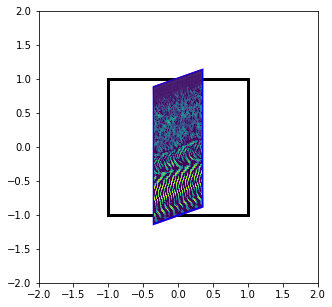

In [5]:
import matplotlib.transforms

def get_xy_from_center(center=(0, 0),
                       w=1.0,
                       h=1.0,
                       theta_deg=np.array([0, 0, 0])):
    '''
    '''
    theta = 2 * np.pi/360 * theta_deg
    
    Rx = np.array([
        [1, 0, 0],
        [0, np.cos(theta[0]), -np.sin(theta[0])],
        [0, np.sin(theta[0]), np.cos(theta[0])],
    ])
    Ry = np.array([
        [np.cos(theta[1]), 0, np.sin(theta[1])],
        [0, 1, 0],
        [-np.sin(theta[1]), 0, np.cos(theta[1])],
    ])
    Rz = np.array([
        [np.cos(theta[2]), -np.sin(theta[2]), 0],
        [np.sin(theta[2]), np.cos(theta[2]), 0],
        [0, 0, 1],
    ])
    xyz_centered = np.array([
        [-w/2, -h/2, 0],
        [-w/2, +h/2, 0],
        [+w/2, +h/2, 0],
        [+w/2, -h/2, 0]
    ])
    xyz = np.zeros_like(xyz_centered)
    xyz[:, 0] = center[0]
    xyz[:, 1] = center[1]
    R = np.matmul(np.matmul(Rx, Ry), Rz)
    xyz_centered = np.matmul(xyz_centered, R)
    xyz = xyz + xyz_centered
    return xyz[:, 0:2]



deg = 20
deg2 = 70
theta_deg = np.array([deg, deg2, -deg])
xy0 = get_xy_from_center(center=(0, 0),
                        w=2.0,
                        h=2.0,
                        theta_deg=np.array([0, 0, 0]))
xy = get_xy_from_center(center=(0, 0),
                        w=2.0,
                        h=2.0,
                        theta_deg=theta_deg)
kwargs_polygon = {
    'lw': 3,
    'fill': False,
    'alpha': 1.0,
}

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

patch = matplotlib.patches.Polygon(xy0, ec='k', zorder=-2, **kwargs_polygon)
ax.add_patch(patch)

patch = matplotlib.patches.Polygon(xy, ec='r', zorder=-1, **kwargs_polygon)
ax.add_patch(patch)

transform = matplotlib.transforms.Affine2D().scale(np.cos(np.deg2rad(deg2)), 1).skew_deg(0, deg)
transform = transform + ax.transData
patch = matplotlib.patches.Polygon(xy0, ec='b', zorder=-0, transform=transform, **kwargs_polygon)
ax.add_patch(patch)

limit = 2
ax.set_xlim([-limit, limit])
ax.set_ylim([-limit, limit])


Z = np.squeeze(out_dict['meanrates'])


im = ax.imshow(Z, aspect='auto', extent=(-1, 1, -1, 1), origin='lower')

im.set_transform(transform)



plt.show()

# print(transform.get_matrix())

